# Softmax exercise

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = "cs231n/datasets/cifar-10-batches-py"
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print("Train data shape: ", X_train.shape)
print("Train labels shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Validation labels shape: ", y_val.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)
print("dev data shape: ", X_dev.shape)
print("dev labels shape: ", y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier
Relevant code: **cs231n/classifiers/softmax.py**. 

In [4]:
# "Naive" non-vectorised implementation.
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss,grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print("loss: %f" % loss)
print("sanity check: %f" % (-np.log(0.1)))

loss: 2.358795
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

10 classes; average probability of each class is 0.1.

In [5]:
# Naively compute the loss and gradient.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Check against the numberical gradient. 
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Repeat with regularisation.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.542245 analytic: -1.542245, relative error: 4.214474e-09
numerical: -0.865091 analytic: -0.865091, relative error: 4.107573e-08
numerical: -2.453627 analytic: -2.453627, relative error: 3.972197e-10
numerical: -0.437026 analytic: -0.437026, relative error: 5.662508e-08
numerical: 0.853795 analytic: 0.853795, relative error: 4.662983e-08
numerical: -4.725355 analytic: -4.725355, relative error: 1.443353e-09
numerical: -0.701516 analytic: -0.701517, relative error: 2.727216e-08
numerical: 1.369218 analytic: 1.369218, relative error: 2.999173e-08
numerical: 0.403970 analytic: 0.403970, relative error: 6.133344e-08
numerical: -0.515913 analytic: -0.515913, relative error: 8.653705e-08
numerical: -3.094188 analytic: -3.098134, relative error: 6.372263e-04
numerical: -1.795476 analytic: -1.796672, relative error: 3.329533e-04
numerical: 2.607247 analytic: 2.608223, relative error: 1.870249e-04
numerical: -1.790186 analytic: -1.788180, relative error: 5.607288e-04
numerical: -0.

In [6]:
# Repeat with vectorised implementation and compare on time.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("naive loss: %e computed in %fs" % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("vectorized loss: %e computed in %fs" % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord="fro")
print("Loss difference: %f" % np.abs(loss_naive - loss_vectorized))
print("Gradient difference: %f" % grad_difference)

naive loss: 2.358795e+00 computed in 0.083899s
vectorized loss: 2.358795e+00 computed in 0.003341s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). 
from cs231n.classifiers import Softmax
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The LinearSVM object that achieved the highest validation rate.

for reg in regularization_strengths:
    for rate in learning_rates:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, rate, reg, num_iters=1500)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax           
        results[(rate,reg)] = train_accuracy,val_accuracy
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("lr %e reg %e train accuracy: %f val accuracy: %f" % (
                lr, reg, train_accuracy, val_accuracy))
    
print("Best validation accuracy achieved during cross-validation: %f" % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.349816 val accuracy: 0.355000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.326122 val accuracy: 0.343000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.103286 val accuracy: 0.106000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.068347 val accuracy: 0.079000
Best validation accuracy achieved during cross-validation: 0.355000


In [8]:
# Evaluate the best softmax on the test set.
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print("softmax on raw pixels final test set accuracy: %f" % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.357000


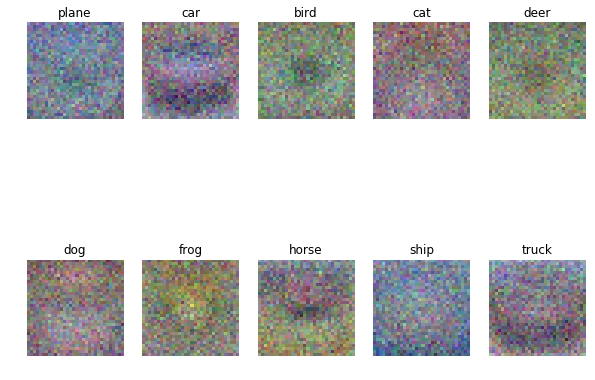

In [9]:
# Visualize the learned weights for each class.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype("uint8"))
    plt.axis("off")
    plt.title(classes[i])